<a href="https://colab.research.google.com/github/syifaniads/ComputerVisionJetsonNano/blob/main/ComputerVision_Riset_Robotik_JetsonNano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ---- 1. Setup dan Instalasi Dependencies ----
!pip install torch torchvision opencv-python matplotlib
!pip install torch torchvision opencv-python matplotlib onnx onnxruntime

import os
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA available: False
Using device: cpu


In [10]:
# ---- 2. Download Model Pre-trained ----
# Menggunakan MobileNetV2 karena ringan dan cocok untuk perangkat edge
model = torchvision.models.mobilenet_v2(pretrained=True)
model = model.to(device)
model.eval()

# Transformasi untuk preprocessing gambar
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [11]:
# ---- 3. Load Label untuk ImageNet ----
# Download labels ImageNet
!wget -q -O imagenet_labels.txt https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_labels.txt") as f:
    labels = [line.strip() for line in f.readlines()]

In [12]:
# ---- 4. Fungsi untuk Inferensi ----
def predict_image(image_path):
    image = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(np.array(image))
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    # Preprocess image
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch)

    # Get top 5 predictions
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    for i in range(5):
        print(f"{labels[top5_catid[i]]}: {top5_prob[i].item()*100:.2f}%")

    return top5_catid, top5_prob

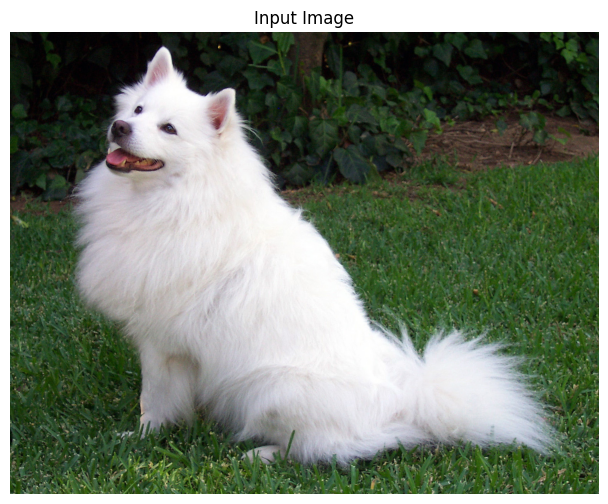

Samoyed: 83.03%
Pomeranian: 6.99%
keeshond: 1.30%
collie: 1.08%
Great Pyrenees: 0.99%


(tensor([258, 259, 261, 231, 257]),
 tensor([0.8303, 0.0699, 0.0130, 0.0108, 0.0099]))

In [13]:
# ---- 5. Contoh Penggunaan dengan Gambar Sample ----
# Download sample image
!wget -q -O sample_image.jpg https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg
predict_image("sample_image.jpg")

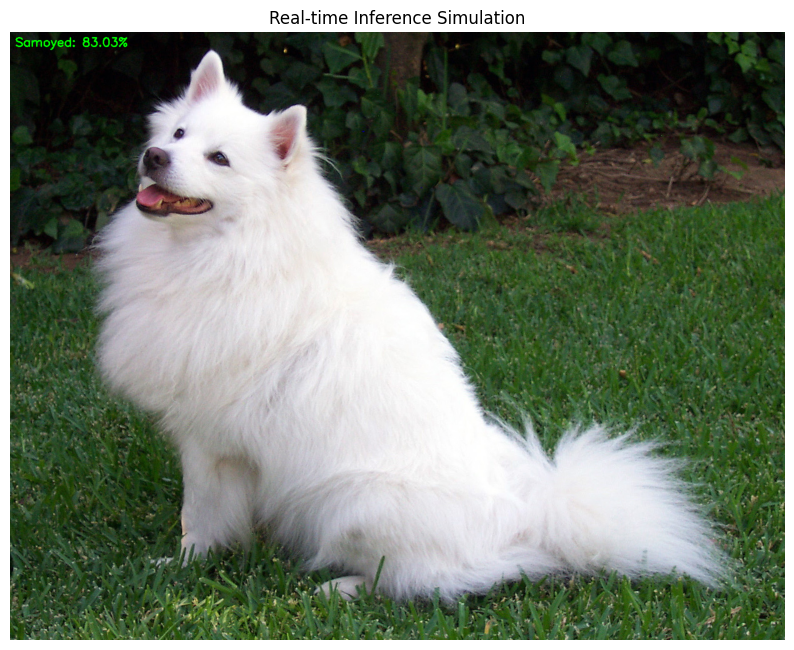

In [14]:
# ---- 6. Real-time Inference dengan OpenCV (simulasi) ----
def webcam_inference_simulation():
    # Menggunakan gambar statis untuk simulasi
    # Di Jetson Nano nanti akan menggunakan webcam/kamera
    image = cv2.imread("sample_image.jpg")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # Preprocess and predict
    input_tensor = preprocess(pil_image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_catid = torch.topk(probabilities, 1)
    prediction = labels[top_catid[0]]
    confidence = top_prob[0].item() * 100

    # Tambahkan teks ke gambar
    cv2.putText(image, f"{prediction}: {confidence:.2f}%",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Display hasil
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Real-time Inference Simulation")
    plt.show()

webcam_inference_simulation()

In [15]:
# ---- 7. Export Model untuk Jetson Nano ----
# Ketika sudah siap dijalankan di Jetson Nano
def export_model():
    # Export model ke ONNX (optimal untuk Jetson Nano)
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    torch.onnx.export(model, dummy_input, "mobilenet_v2.onnx",
                     verbose=True,
                     input_names=['input'],
                     output_names=['output'],
                     opset_version=11)
    print("Model exported to ONNX format")

export_model()

Model exported to ONNX format


In [8]:
# ---- 8. Kode untuk Jetson Nano (akan dijalankan nanti di Jetson) ----
"""
Di bawah ini adalah kode yang akan dijalankan di Jetson Nano
setelah pengujian di Colab selesai:

# Di Jetson Nano:
import cv2
import time
import numpy as np
import onnxruntime as ort

# Load ONNX model
ort_session = ort.InferenceSession("mobilenet_v2.onnx")

# Setup kamera
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

# Load labels
with open("imagenet_labels.txt") as f:
    labels = [line.strip() for line in f.readlines()]

# Preprocessing functions
def preprocess(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.transpose(2, 0, 1).astype(np.float32)
    img /= 255.0
    img = (img - np.array([0.485, 0.456, 0.406])[:, None, None]) / np.array([0.229, 0.224, 0.225])[:, None, None]
    return img[None, :]

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocessing
    input_data = preprocess(frame)

    # Inference
    start = time.time()
    outputs = ort_session.run(None, {'input': input_data})
    inference_time = (time.time() - start) * 1000

    # Get prediction
    scores = outputs[0][0]
    idx = np.argmax(scores)
    prob = np.exp(scores[idx]) / np.sum(np.exp(scores))
    label = labels[idx]

    # Display hasil
    cv2.putText(frame, f"{label}: {prob:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(frame, f"Inference: {inference_time:.1f}ms",
                (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow("Jetson Nano CV Demo", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
"""

'\nDi bawah ini adalah kode yang akan dijalankan di Jetson Nano\nsetelah pengujian di Colab selesai:\n\n# Di Jetson Nano:\nimport cv2\nimport time\nimport numpy as np\nimport onnxruntime as ort\n\n# Load ONNX model\nort_session = ort.InferenceSession("mobilenet_v2.onnx")\n\n# Setup kamera\ncap = cv2.VideoCapture(0)\ncap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)\ncap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)\n\n# Load labels\nwith open("imagenet_labels.txt") as f:\n    labels = [line.strip() for line in f.readlines()]\n\n# Preprocessing functions\ndef preprocess(img):\n    img = cv2.resize(img, (224, 224))\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    img = img.transpose(2, 0, 1).astype(np.float32)\n    img /= 255.0\n    img = (img - np.array([0.485, 0.456, 0.406])[:, None, None]) / np.array([0.229, 0.224, 0.225])[:, None, None]\n    return img[None, :]\n\nwhile True:\n    ret, frame = cap.read()\n    if not ret:\n        break\n    \n    # Preprocessing\n    input_data = preprocess(frame)\n 